In [6]:
!pip install nltk keras matplotlib seaborn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

print("✅ Libraries imported and ready!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Libraries imported and ready!


In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive (2).zip to archive (2).zip


In [3]:
import zipfile
import os


with zipfile.ZipFile('archive (2).zip', 'r') as zip_ref:
    zip_ref.extractall('.')


os.listdir('.')


['.config',
 'archive (2).zip',
 'training.1600000.processed.noemoticon.csv',
 'sample_data']

In [4]:
# Loading CSV
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = df[['target', 'text']]

# Maping target to labels
sentiment_map = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
df['target'] = df['target'].map(sentiment_map)

df.head()


,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [7]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(filtered)

# Applying cleaning
df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text', 'target']].head()


,text,cleaned_text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...,Negative
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,Negative
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest bounds,Negative
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire,Negative
4,"@nationwideclass no, it's not behaving at all....",behaving mad cant see,Negative


In [8]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y = df['target'].map(label_map).values

print("✅ Tokenization and padding complete!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


✅ Tokenization and padding complete!
X shape: (1600000, 100)
y shape: (1600000,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Building LSTM
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)


Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1517s 151ms/step - accuracy: 0.4996 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1535s 153ms/step - accuracy: 0.5005 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1592s 154ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1530s 153ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1537s 154ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931


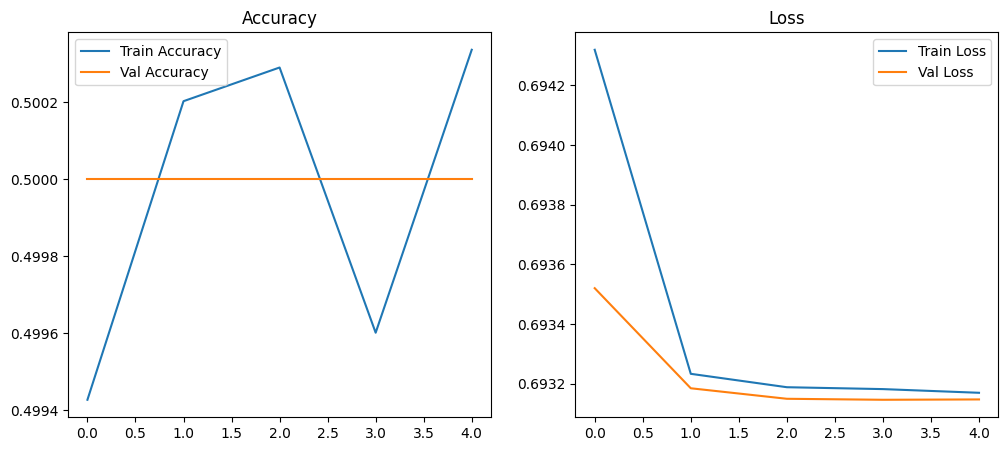

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy:.4f}")


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 158s 16ms/step - accuracy: 0.5011 - loss: 0.6931
✅ Test Accuracy: 0.5000


In [13]:
from sklearn.utils.multiclass import unique_labels

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

labels_present = sorted(list(unique_labels(y_test, y_pred)))
label_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
present_names = [label_dict[i] for i in labels_present]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels_present, target_names=present_names))


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 150s 15ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    160000
    Positive       0.00      0.00      0.00    160000

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


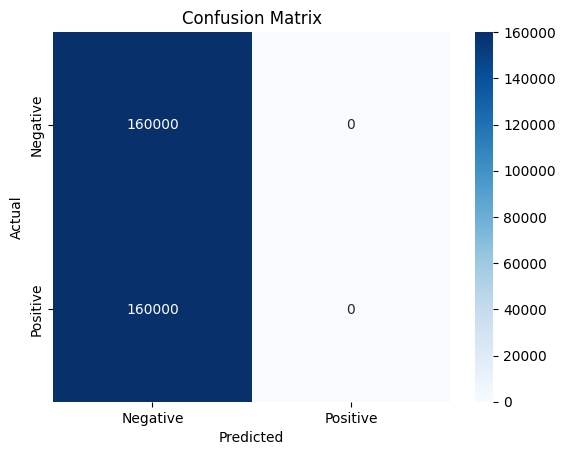

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_names, yticklabels=present_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [15]:
def predict_sentiment(text):
    text_clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    pred = model.predict(padded)
    label = np.argmax(pred)
    sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment[label]

# Trying samples
print(predict_sentiment("I love using Google Colab!"))
print(predict_sentiment("This product is the worst I've ever used."))
print(predict_sentiment("It's okay, not too bad, not too great."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Negative


In [16]:
model.save("sentiment_lstm_model.h5")
print("✅ Model saved!")


from google.colab import files
files.download("sentiment_lstm_model.h5")


✅ Model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>